# Prediction E-Coli Protein Localization Site

In [210]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from random import shuffle
from sklearn.preprocessing import LabelEncoder

## Load in the dataset

In [211]:
# Download the dataset
!wget https://lazyprogrammer.me/course_files/exercises/ecoli.csv

--2025-04-15 13:54:32--  https://lazyprogrammer.me/course_files/exercises/ecoli.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19487 (19K) [text/csv]
Saving to: 'ecoli.csv.1'

     0K .......... .........                                  100% 5,41M=0,003s

2025-04-15 13:54:32 (5,41 MB/s) - 'ecoli.csv.1' saved [19487/19487]



In [212]:
%%bash
head ecoli.csv

AAT_ECOLI   0.49  0.29  0.48  0.50  0.56  0.24  0.35   cp
ACEA_ECOLI  0.07  0.40  0.48  0.50  0.54  0.35  0.44   cp
ACEK_ECOLI  0.56  0.40  0.48  0.50  0.49  0.37  0.46   cp
ACKA_ECOLI  0.59  0.49  0.48  0.50  0.52  0.45  0.36   cp
ADI_ECOLI   0.23  0.32  0.48  0.50  0.55  0.25  0.35   cp
ALKH_ECOLI  0.67  0.39  0.48  0.50  0.36  0.38  0.46   cp
AMPD_ECOLI  0.29  0.28  0.48  0.50  0.44  0.23  0.34   cp
AMY2_ECOLI  0.21  0.34  0.48  0.50  0.51  0.28  0.39   cp
APT_ECOLI   0.20  0.44  0.48  0.50  0.46  0.51  0.57   cp
ARAC_ECOLI  0.42  0.40  0.48  0.50  0.56  0.18  0.30   cp


In [213]:
data = pd.read_csv("ecoli.csv", header=None, sep=r'\s+', usecols=range(1, 9)).to_numpy()

No need for standardize the features since they're pretty small already

In [286]:
# Split the features and targets
X, y = data[:, :-1], data[:, -1]

#### Convert y to array of integers

In [287]:
le = LabelEncoder()
y = le.fit_transform(y)
encode_map = le.classes_

In [288]:
X.shape, y.shape, y.dtype

((336, 7), (336,), dtype('int32'))

In [289]:
# Split into train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
X_train.shape, X_test.shape

((268, 7), (68, 7))

In [290]:
# Convert to Torch tensor
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.longlong))
y_test = torch.from_numpy(y_test.astype(np.longlong))

### Build the model

In [357]:
# Hyperparameters
lr = 0.002
num_epochs = 1000
num_hiddens = 128
drop_out_p = 0.01
optim = "Adam"

In [347]:
def create_model(num_ins, num_outs, num_hiddens, drop_out_p):
    model = nn.Sequential(
        nn.Linear(num_ins, num_hiddens),
        nn.ReLU(),
        nn.Dropout(drop_out_p),
        nn.Linear(num_hiddens, num_outs),
        nn.Dropout(drop_out_p)
        # No need for softmax since it's used in our loss function
    )
    return model

In [293]:
def configure(model, lr, optim):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) if optim == "Adam" \
        else torch.optim.SGD(model.parameters(), lr=lr)
    return criterion, optimizer

#### Gradient Descend

In [294]:
def train(model, X_train, y_train, X_test, y_test, optimizer, criterion, num_epochs, record_loss=False):
    loss_history = np.zeros(num_epochs)
    test_history = np.zeros(num_epochs)
    
    for epoch in range(num_epochs):
        # Zero out the gradient
        optimizer.zero_grad()
        
        # Compute the loss
        y_hat_train = model(X_train)
        loss = criterion(y_hat_train, y_train)
        
        # Compute test loss
        y_hat_test = model(X_test)
        
        # Update params
        loss.backward()
        optimizer.step()
        
        # Record the losses
        loss_history[epoch] = loss.item()
        test_history[epoch] = criterion(y_hat_test, y_test).item()
    
    return loss_history, test_history

In [358]:
model = create_model(X_train.shape[1], 8, num_hiddens, drop_out_p)
criterion, optimizer = configure(model, lr, optim)

In [359]:
loss_history, test_history = train(model, X_train, y_train, X_test, y_test, optimizer, criterion, num_epochs)

### Evaluate the model

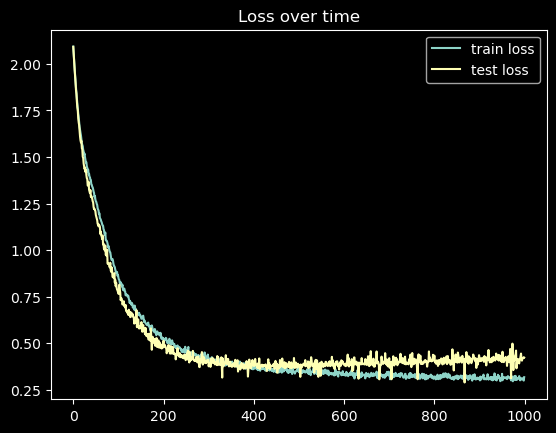

In [360]:
plt.title("Loss over time")
plt.plot(loss_history, label="train loss")
plt.plot(test_history, label="test loss")
plt.legend()
plt.show()

In [361]:
# Switch to evaluating mode (Ignore drop out layer)
model.eval()

Sequential(
  (0): Linear(in_features=7, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.01, inplace=False)
  (3): Linear(in_features=128, out_features=8, bias=True)
  (4): Dropout(p=0.01, inplace=False)
)

In [362]:
n_correct, n_total = 0, y_train.shape[0]
y_hat_train = model(X_train)
_, predictions = torch.max(y_hat_train, 1) 
n_correct += (predictions == y_train).sum().item()
print(f"Training accuracy: {n_correct/n_total:.4f}")

Training accuracy: 0.8881


In [363]:
n_correct, n_total = 0, y_test.shape[0]
y_hat_test = model(X_test)
_, predictions = torch.max(y_hat_test, 1) 
n_correct += (predictions == y_test).sum().item()
print(f"Testing accuracy: {n_correct/n_total:.4f}")

Testing accuracy: 0.9118


#### Plot confusion matrix

In [301]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Cofusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix
    Normalization can be applied by setting normalized to True
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else: 
        print("Confusion matrix with no normalization")
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tickmarks = np.arange(len(classes))
    plt.xticks(tickmarks, classes, rotation=45)
    plt.yticks(tickmarks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Confusion matrix with no normalization
[[108   1   0   0   0   0   0   2]
 [  2  54   0   0   7   0   0   0]
 [  0   0   2   0   0   0   0   0]
 [  0   0   0   0   0   0   0   1]
 [  1   9   0   0  16   0   0   0]
 [  0   0   0   0   0  15   0   2]
 [  0   0   0   0   0   0   5   0]
 [  4   1   0   0   0   0   0  38]]


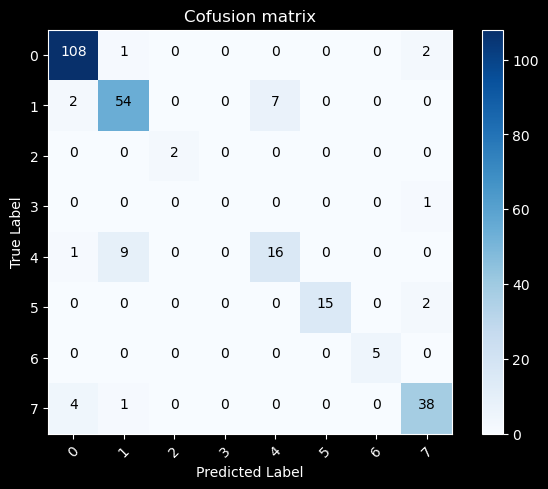

In [364]:
y_hat_train = model(X_train)
_, predictions = torch.max(y_hat_train, 1)
p_test = predictions.numpy()

cm = confusion_matrix(y_train.numpy(), p_test)
plot_confusion_matrix(cm, list(range(8)))